In [1]:
import pickle
from typing import NamedTuple
from types import SimpleNamespace
from src.internal_typing import SpectralData
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'std-colors'])
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.rcParams['font.size'] = 8
from matplotlib.lines import Line2D
import numpy as np
from numpy.typing import NDArray
from scipy.stats import linregress

In [8]:
file_paths = {
    'RRR': 'data/RRR_RBF.pkl',
    'PCR': 'data/PCR_RBF.pkl'
}
simulations = {}
for algorithm in file_paths.keys():
    with open(file_paths[algorithm], 'rb') as f:
        simulations[algorithm] = pickle.load(f)

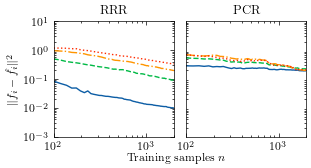

In [27]:
pt_to_inch = 0.0138889
width_pts = 234.8775
width_inches = width_pts*pt_to_inch
fig, axes = plt.subplots(ncols = 2, figsize = (width_inches, 1.5))
plt.subplots_adjust(wspace=0.1)

plot_configs = {
    'yscale': 'log',
    'xscale': 'log',
    'ylim': (1e-3, 10)
}

lss = [
    'solid',
    'dashed',
    'dashdot',
    'dotted'
]

mode = 'ef'
rates = {}
for algorithm in simulations.keys():
    slopes = np.zeros((4,), dtype=np.float64)
    if algorithm == 'RRR':
        ax_idx = 0
    else:
        ax_idx = 1
    ax = axes[ax_idx]
    simulation = simulations[algorithm]     
    for idx in range(4):
        if mode == 'eigenvalues':
            err = simulation.evalues_err.mean[:, idx]
        else:
            err = simulation.efuncs_err.mean[:, idx]

        lin_fit = linregress(np.log(simulation.training_sizes), np.log(err))
        slopes[idx] = lin_fit.slope
        ax.plot(simulation.training_sizes, err, color=colors[idx], ls = lss[idx])
    ax.set(**plot_configs)
    ax.set_title(algorithm,fontsize=9)
    ax.margins(x=0)
    rates[algorithm] = slopes
    if algorithm == 'RRR':
        if mode == 'eigenvalues':
            ax.set_ylabel(r'$|\mu_{i} - \hat{\lambda}_{i} |$')
        else:
            ax.set_ylabel(r'$\|f_{i} - \hat{f}_{i} \|^{2}$')
    else:
        ax.set_yticks([])

fig.text(0.5, -0.05, 'Training samples $n$', ha='center')
fig.savefig('figs/error_decay_rate_eigenfunctions.pdf')

In [28]:
import pandas as pd

In [29]:
functions = pd.DataFrame.from_dict(rates)

In [30]:
print(functions.style.to_latex())

\begin{tabular}{lrr}
 & RRR & PCR \\
0 & -0.635680 & -0.139309 \\
1 & -0.577666 & -0.326457 \\
2 & -0.573375 & -0.505743 \\
3 & -0.476403 & -0.450845 \\
\end{tabular}



### Eigenfunctions

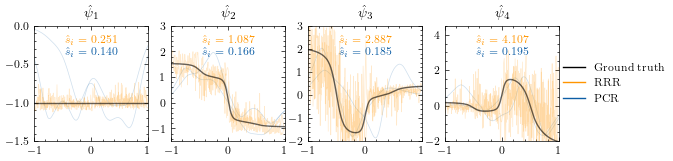

In [7]:
func_idx = 1
algorithm = 'PCR'
pt_to_inch = 0.0138889
width_pts = 487.8225
width_inches = width_pts*pt_to_inch

fig, ax = plt.subplots(ncols=4, figsize=(width_inches, 1.5))
true_func = simulations['RRR'].FEM_spectrum.vectors
x = simulations['RRR'].x

RRR_funs = simulations['RRR'].MD_spectrum.vectors[-1]
PCR_funs = simulations['PCR'].MD_spectrum.vectors[-1]


additional_info = [
    {
        'ylim': (-1.5, 0),
        'RRR': simulations['RRR'].total_bias.mean[-1, 0],
        'PCR': simulations['PCR'].total_bias.mean[-1, 0]
    },
    {
        'ylim': (-1.5, 3.0),
        'RRR': simulations['RRR'].total_bias.mean[-1, 1],
        'PCR': simulations['PCR'].total_bias.mean[-1, 1]
    },
    {
        'ylim': (-2, 3.0),
        'RRR': simulations['RRR'].total_bias.mean[-1, 2],
        'PCR': simulations['PCR'].total_bias.mean[-1, 2]
    },
    {
        'ylim': (-2, 4.5),
        'RRR': simulations['RRR'].total_bias.mean[-1, 3],
        'PCR': simulations['PCR'].total_bias.mean[-1, 3]
    },

]

for func_idx in range(4):
    info = SimpleNamespace(**additional_info[func_idx])
    plot_settings = {
        'xlim': (-1, 1),
        'ylim': info.ylim,
        'title': r'$\hat{\psi}_{' + str(func_idx + 1) + r'}$'
    }
    ax[func_idx].plot(x, PCR_funs[...,func_idx].T, c=colors[0], lw=0.5, alpha=0.2)
    ax[func_idx].plot(x, RRR_funs[...,func_idx].T, c=colors[2], lw=0.5, alpha=0.2)
    ax[func_idx].plot(x, true_func[:, func_idx], c='k', alpha=0.6)
    ax[func_idx].set(**plot_settings)
    ax[func_idx].text(x = 0.5, y = 0.85, s=r"$\hat{s}_{i} = $ " + f"{info.RRR:.3f}", c=colors[2], transform=ax[func_idx].transAxes, ha='center')
    ax[func_idx].text(x = 0.5, y = 0.75, s=r"$\hat{s}_{i} = $ " + f"{info.PCR:.3f}", c=colors[0], transform=ax[func_idx].transAxes, ha='center')
legend_elements = [
    Line2D([0], [0], color='k', label='Ground truth'),
    Line2D([0], [0], color=colors[2], label='RRR'),
    Line2D([0], [0], color=colors[0], label='PCR')
]
fig.legend(handles = legend_elements, bbox_to_anchor=(1.0, 0.5, 0.07, 0.2))
fig.savefig('figs/eigenfunc_approximation.pdf')